In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import re
from sklearn import preprocessing
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from keras.utils import pad_sequences
from tensorflow.python.client import device_lib
from keras.constraints import maxnorm
from keras.layers import Dropout
import time
import nltk
import warnings
warnings.filterwarnings("ignore")


In [125]:
df = pd.read_excel("C:/Users/jllce/Downloads/classificacao_assuntos.xlsx")

In [126]:
df.isnull().sum()

tweets    0
label     0
dtype: int64

In [127]:
# Se tiver valores nulos, usar o código abaixo

# df = df[~df['label'].isnull()]
# df

In [134]:
df1 = df["tweets"]

In [111]:
def cleanTxt(text):
  import re
  text = text.lower()
  text = re.sub(r"@([a-zA-Z0-9_]{1,50})",'',str(text)) 
  text = re.sub(r'(?:\@|https?\://)\S+','',text)
  text = re.sub(r'\d+','', text)
  text = re.sub(r"[-()\"#/;:<>{}-~=|.?,]","",text)
  return text

def removeEmojis(text):
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
        "]+", re.UNICODE)
  text = emoji_pattern.sub(r'', text)
  return text

def removeStopWords(text):
    stemmer = nltk.stem.RSLPStemmer()
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    words = [stemmer.stem(i) for i in text.split() if not i in stopwords]
    return (" ".join(words))


tweets_tratados = df1.apply(cleanTxt)
tweets_tratados = tweets_tratados.apply(removeEmojis)
tweets_tratados = tweets_tratados.apply(removeStopWords)

In [112]:
tweets_tratados.isnull().sum()

0

In [113]:
max_words = []
for row in tweets_tratados:
    max_words.append(len(row.split()))
print(f"The max word count is {np.asarray(max_words).max()}")



The max word count is 47


In [138]:
le = LabelEncoder()
df['label_num'] = le.fit_transform(df["label"])

label_dict = (df[['label','label_num']].drop_duplicates()
              .sort_values(by='label_num')
              .reset_index(drop=True)['label']
              .to_dict())

for index, key in label_dict.items():
    print(index, key)

0 Atendimento
1 Entrega
2 Outro
3 Produto


In [139]:
labels = pd.DataFrame(df["label_num"])
labels

,label_num
0,2
1,1
2,1
3,1
4,0
...,...
18104,2
18105,2
18106,0
18107,3


In [ ]:
labels.value_counts()

Label
2        8385
1        4819
3        2961
0        1944
dtype: int64

In [85]:
from keras.utils.np_utils import to_categorical
y = to_categorical(labels)

In [86]:
y.shape

(18109, 4)

In [87]:
# preparar tokenizer
tweets = list(tweets_tratados)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)

In [88]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11579 unique tokens.


In [89]:
# integer codificar os documentos
sequences = tokenizer.texts_to_sequences(tweets)

In [90]:
# preencher documentos com um comprimento máximo de 28 palavras
maxlen = np.asarray(max_words).max()
X = pad_sequences(sequences, maxlen=maxlen)

In [91]:
X.shape

(18109, 47)

In [92]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [93]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12676, 47), (5433, 47), (12676, 4), (5433, 4))

In [94]:
# SimpleRNN
vocab_size = len(word_index) + 1
output_dim = 32
maxlen = maxlen
model = Sequential()
model.add(Embedding(vocab_size, output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [95]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 47, 32)            370560    
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 47, 32)            2080      
                                                                 
 dropout_8 (Dropout)         (None, 47, 32)            0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 47, 32)            2080      
                                                                 
 dropout_9 (Dropout)         (None, 47, 32)            0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 4)                

In [96]:
model.save('srnn.h5')

In [97]:
start = time.time()

# Ajustar o modelo ao conjunto de treino
rnn_hist = model.fit(X_train, y_train, epochs=10, validation_split=0.3)
# Avaliação final do modelo
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")

end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Epoch 1/10
278/278 [==============================] - 18s 47ms/step - loss: 0.9843 - accuracy: 0.6152 - val_loss: 0.7569 - val_accuracy: 0.7147
Epoch 2/10
278/278 [==============================] - 13s 47ms/step - loss: 0.6127 - accuracy: 0.7785 - val_loss: 0.6960 - val_accuracy: 0.7531
Epoch 3/10
278/278 [==============================] - 13s 46ms/step - loss: 0.3778 - accuracy: 0.8765 - val_loss: 0.7454 - val_accuracy: 0.7544
Epoch 4/10
278/278 [==============================] - 13s 47ms/step - loss: 0.2442 - accuracy: 0.9230 - val_loss: 0.7818 - val_accuracy: 0.7618
Epoch 5/10
278/278 [==============================] - 14s 50ms/step - loss: 0.1724 - accuracy: 0.9484 - val_loss: 0.8364 - val_accuracy: 0.7718
Epoch 6/10
278/278 [==============================] - 13s 47ms/step - loss: 0.1399 - accuracy: 0.9557 - val_loss: 0.9299 - val_accuracy: 0.7528
Epoch 7/10
278/278 [==============================] - 12s 45ms/step - loss: 0.1104 - accuracy: 0.9663 - val_loss: 0.9966 - val_accuracy:

In [98]:
model = Sequential()
model.add(Embedding(vocab_size,output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(LSTM(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim, kernel_constraint=maxnorm(3)))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
warnings.filterwarnings("ignore")

In [99]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 47, 32)            370560    
                                                                 
 lstm_6 (LSTM)               (None, 47, 32)            8320      
                                                                 
 dropout_10 (Dropout)        (None, 47, 32)            0         
                                                                 
 lstm_7 (LSTM)               (None, 47, 32)            8320      
                                                                 
 dropout_11 (Dropout)        (None, 47, 32)            0         
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_5 (Dense)             (None, 4)                

In [100]:
model.save('lstm.h5')

In [101]:
start = time.time()
# Ajustar o modelo ao conjunto de treino
lstm_hist = model.fit(X_train, y_train, epochs=10, validation_split=0.3)
# avaliação final do modelo
warnings.filterwarnings("ignore")
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")
end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Epoch 1/10
278/278 [==============================] - 33s 91ms/step - loss: 0.9410 - accuracy: 0.6286 - val_loss: 0.7280 - val_accuracy: 0.7257
Epoch 2/10
278/278 [==============================] - 28s 101ms/step - loss: 0.6213 - accuracy: 0.7677 - val_loss: 0.6699 - val_accuracy: 0.7541
Epoch 3/10
278/278 [==============================] - 24s 88ms/step - loss: 0.4839 - accuracy: 0.8305 - val_loss: 0.6211 - val_accuracy: 0.7852
Epoch 4/10
278/278 [==============================] - 27s 95ms/step - loss: 0.3572 - accuracy: 0.8838 - val_loss: 0.6313 - val_accuracy: 0.7931
Epoch 5/10
278/278 [==============================] - 26s 95ms/step - loss: 0.2856 - accuracy: 0.9132 - val_loss: 0.6926 - val_accuracy: 0.7710
Epoch 6/10
278/278 [==============================] - 29s 103ms/step - loss: 0.2522 - accuracy: 0.9216 - val_loss: 0.7176 - val_accuracy: 0.7796
Epoch 7/10
278/278 [==============================] - 28s 101ms/step - loss: 0.2283 - accuracy: 0.9274 - val_loss: 0.7272 - val_accura

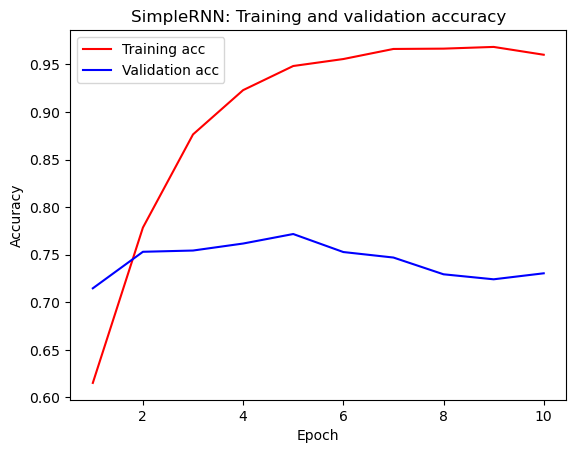

In [102]:
# SimpleRNN Result

acc = rnn_hist.history['accuracy']
val_acc = rnn_hist.history['val_accuracy']
loss = rnn_hist.history['loss']
val_loss = rnn_hist.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('SimpleRNN: Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

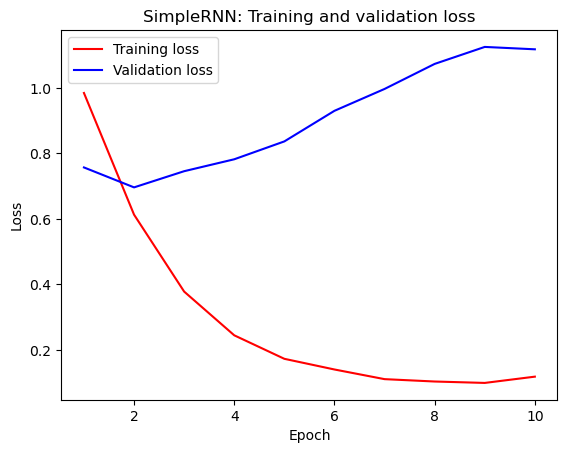

In [103]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('SimpleRNN: Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

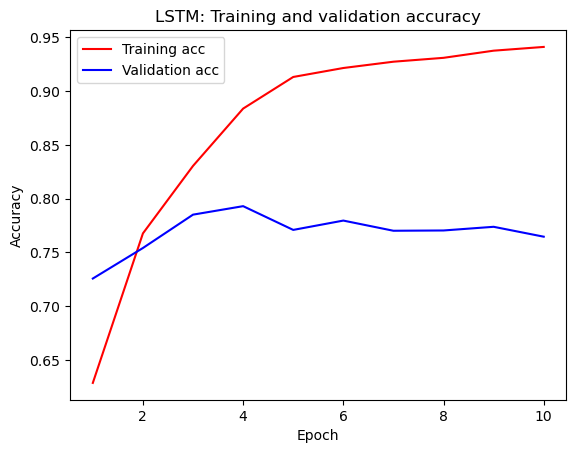

In [104]:
# LSTM Result

acc = lstm_hist.history['accuracy']
val_acc = lstm_hist.history['val_accuracy']
loss = lstm_hist.history['loss']
val_loss = lstm_hist.history['val_loss']
epochs = range(1, len(acc)+1)
_ = plt.plot(epochs, acc, 'r', label='Training acc')
_ = plt.plot(epochs, val_acc, 'b', label='Validation acc')
_ = plt.title('LSTM: Training and validation accuracy')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend(loc='best')
plt.show()

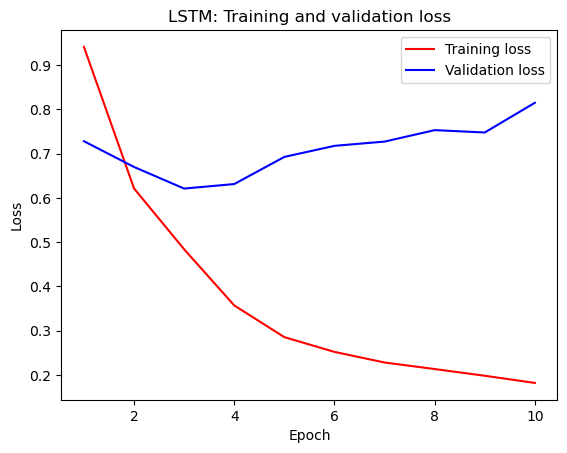

In [105]:
_ = plt.plot(epochs, loss, 'r', label='Training loss')
_ = plt.plot(epochs, val_loss, 'b', label='Validation loss')
_ = plt.title('LSTM: Training and validation loss')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend(loc='best')
plt.show()

In [69]:
from keras.models import load_model
lstm = load_model('lstm.h5')
warnings.filterwarnings("ignore")

In [70]:
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 28, 32)            370560    
                                                                 
 lstm_3 (LSTM)               (None, 28, 32)            8320      
                                                                 
 dropout_6 (Dropout)         (None, 28, 32)            0         
                                                                 
 lstm_4 (LSTM)               (None, 28, 32)            8320      
                                                                 
 dropout_7 (Dropout)         (None, 28, 32)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 4)                

In [71]:
predictions = lstm.predict(X_test)

170/170 [==============================] - 4s 15ms/step
